<a href="https://colab.research.google.com/github/renan-peres/mfin-portfolio-management/blob/main/01_portfolio_construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short-Term Equity Portfolio -- ***15% of Complete Portfolio***
The goal is to select the top 10 most popular stocks on news and selecting a strategy ***(based on sentiment analysis and technical indicators)*** while adhering to these following constraints:

### Step 1: Import Libraries

In [1]:
# System libraries
import glob
import os
import sys
from io import StringIO
from typing import Dict, List

# Data manipulation libraries
import polars as pl
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

# Visualization libraries
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Backtesting library
import bt

In [2]:
import logging
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Suppress yfinance progress bars
os.environ['YFINANCE_PROGRESS'] = 'False'

# Create logger instance
logger = logging.getLogger(__name__)

logging.getLogger('bt').disabled = True
logging.getLogger('yfinance').disabled = True

# Alternative: Set logging level to critical
logging.getLogger('bt').setLevel(logging.CRITICAL)
logging.getLogger('yfinance').setLevel(logging.CRITICAL)

### Step 2: Define Parameters

#### Date Range

In [3]:
# Define the date range
end_date = (datetime.today() - BDay(1)).to_pydatetime()  # Subtract 1 business day
start_date = end_date - timedelta(days=10*365)            

# Convert datetime objects to Unix timestamps (seconds since Jan 1, 1970)
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())

# Print the date range
days_difference = (end_date - start_date).days
print(f"Date Range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Time span: {days_difference} days ({days_difference/365:.2f} years)")

Date Range: 2015-06-06 to 2025-06-03
Time span: 3650 days (10.00 years)


#### Risk-free rate (T-bill, %)

In [4]:
from py.utils import load_and_filter_data

daily_risk_free_df = load_and_filter_data('data/daily_treasury_rates.csv', ['^IRX'], start_date, end_date)
# risk_free_rate = .0433
risk_free_rate = daily_risk_free_df.iloc[-1, 0] / 100
print("Risk-Free Rate:", risk_free_rate, "-- 13 WEEK TREASURY BILL (^IRX)")

Found 1 of 1 tickers in data/daily_treasury_rates.csv
Missing tickers: []
Risk-Free Rate: 0.042300000000000004 -- 13 WEEK TREASURY BILL (^IRX)


#### Portfolio File

In [5]:
# Get the most recent portfolio file
portfolio_files = glob.glob('portfolios/portfolio-*.xlsx')
if portfolio_files:
    # Sort files by modification time (most recent first)
    output_file = max(portfolio_files, key=os.path.getmtime)
    print(f"Using most recent portfolio file: {output_file}")
else:
    # Fallback to current date if no files found
    output_file = f'portfolios/portfolio-{datetime.date(end_date)}.xlsx'
    print(f"No portfolio files found. Using: {output_file}")

Using most recent portfolio file: portfolios/portfolio-2025-06-02.xlsx


### Step 3: Import News Data (FMP API)
- API Documentation: https://site.financialmodelingprep.com/developer/docs/stable/stock-news

In [6]:
from py.fetch_fmp_api import create_session, fetch_data
from dotenv import load_dotenv
load_dotenv()

# Get API key from environment variables
FMP_API_KEY = os.getenv('FMP_API_KEY')
if not FMP_API_KEY:
    raise ValueError("FMP_API_KEY not found in environment variables")

# Configuration variables for fetch_data function
DAYS_BACK = 7                    # Number of days to look back for news
MAX_PAGES = 10                   # Maximum number of pages to fetch
RECORDS_PER_PAGE = 1000          # Number of records per page
REQUEST_TIMEOUT = 10             # Timeout for API requests in seconds
API_BASE_URL = "https://financialmodelingprep.com/api/v3/stock_news"
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"  # Date format for parsing publishedDate

# Create session and fetch data with all required parameters
session = create_session()
data = fetch_data(
    api_key=FMP_API_KEY,
    session=session,
    days_back=30,           # Custom: 30 days back
    max_pages=15,           # Custom: 15 pages
    records_per_page=1000,  
    request_timeout=10      
)

news_df = pl.DataFrame(data)
display(news_df.sort('publishedDate', descending=True).head())

Fetching page 1/15...
Page 1: 1000 articles fetched
Fetching page 2/15...
Page 2: 999 articles fetched
Fetching page 3/15...
Page 3: 999 articles fetched
Fetching page 4/15...
Page 4: 1000 articles fetched
Fetching page 5/15...
Page 5: 998 articles fetched
Fetching page 6/15...
Page 6: 1000 articles fetched
Fetching page 7/15...
Page 7: 1000 articles fetched
Fetching page 8/15...
Page 8: 1000 articles fetched
Fetching page 9/15...
Page 9: 999 articles fetched
Fetching page 10/15...
Page 10: 1000 articles fetched
Fetching page 11/15...
Page 11: 996 articles fetched
Fetching page 12/15...
Page 12: 1000 articles fetched
Fetching page 13/15...
Page 13: 1000 articles fetched
Fetching page 14/15...
Page 14: 1000 articles fetched
Fetching page 15/15...
Page 15: 1000 articles fetched
Total articles fetched: 14991


symbol,publishedDate,title,image,site,text,url
str,str,str,str,str,str,str
"""GGP""","""2025-06-04 12:07:00""","""Greatland Gold provides a road…","""https://images.financialmodeli…","""https://www.proactiveinvestors…","""Greatland Gold has just droppe…","""https://www.proactiveinvestors…"
"""RIVN""","""2025-06-04 11:59:10""","""Rivian Automotive, Inc. (RIVN)…","""https://images.financialmodeli…","""seekingalpha.com""","""Rivian Automotive, Inc. (NASDA…","""https://seekingalpha.com/artic…"
"""UBER""","""2025-06-04 11:57:53""","""Uber expansion into underpenet…","""https://images.financialmodeli…","""proactiveinvestors.com""","""Uber Technologies Inc (NYSE:UB…","""https://www.proactiveinvestors…"
"""MRVL""","""2025-06-04 11:57:14""","""Marvell: Still A Buying Opport…","""https://images.financialmodeli…","""seekingalpha.com""","""Marvell's stock is deeply unde…","""https://seekingalpha.com/artic…"
"""GM""","""2025-06-04 11:56:07""","""GM vs. TM: How Do These Legacy…","""https://images.financialmodeli…","""zacks.com""","""Toyota's hybrid strength, glob…","""https://www.zacks.com/stock/ne…"


### Step 4: Sentiment Analysis
- Use `TextBlob` for sentiment analysis on news headlines.


In [7]:
from py.sentiment_analysis import calculate_stock_sentiment_metrics, get_fundamental_value, calculate_sector_averages

# Load fundamental data and prepare ticker lists
print("Loading fundamental data...")
fundamentals_df = pl.read_csv('data/fundamentals_stock.csv')
fundamentals_pandas = fundamentals_df.to_pandas().set_index('Ticker')
all_tickers = set(news_df['symbol'].to_list() + fundamentals_df['Ticker'].to_list())
EXCLUDED_SYMBOLS = {'AI', 'S', 'A', 'U', 'E', 'US', 'ET', 'TSXV', 'CODI', 'C'}

print(f"Loaded {len(fundamentals_df)} stocks, {len(all_tickers)} unique tickers")

# Execute sentiment analysis
print("Analyzing sentiment for stock symbols...")
sentiment_metrics = calculate_stock_sentiment_metrics(news_df, all_tickers, EXCLUDED_SYMBOLS)
sentiment_df = pl.DataFrame([{
    "symbol": symbol, "articlesInLastWeek": metrics["articlesInLastWeek"],
    "companyNewsScore": metrics["companyNewsScore"], 
    "bearishPercent": metrics["sentiment"]["bearishPercent"],
    "bullishPercent": metrics["sentiment"]["bullishPercent"],
    "averageSentimentScore": metrics["averageSentimentScore"],
    "totalArticles": metrics["totalArticles"]
} for symbol, metrics in sentiment_metrics.items()]).sort(["articlesInLastWeek", "companyNewsScore"], descending=[True, True])

# Add fundamental data and sector averages
sector_averages = calculate_sector_averages(sentiment_df, fundamentals_pandas)
sentiment_with_fundamentals = sentiment_df.with_columns([
    pl.col("symbol").map_elements(lambda x: sector_averages.get(get_fundamental_value(x, 'Sector', 'Unknown'), {}).get('sectorAverageBullishPercent', 0), return_dtype=pl.Float64).alias("sectorAverageBullishPercent"),
    pl.col("symbol").map_elements(lambda x: sector_averages.get(get_fundamental_value(x, 'Sector', 'Unknown'), {}).get('sectorAverageNewsScore', 0), return_dtype=pl.Float64).alias("sectorAverageNewsScore"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Sector', 'Unknown'), return_dtype=pl.Utf8).alias("sector"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Market Cap'), return_dtype=pl.Float64).alias("marketCap"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'P/E (trailing)'), return_dtype=pl.Float64).alias("peRatio"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Price'), return_dtype=pl.Float64).alias("price")
])

# Screen stocks and analyze sectors
comprehensive_screened = sentiment_with_fundamentals.filter((pl.col("articlesInLastWeek") >= 3) & (pl.col("companyNewsScore") >= 0.45)).sort(["companyNewsScore", "articlesInLastWeek"], descending=[True, True])
sector_summary = sentiment_with_fundamentals.filter(pl.col("sector") != "Unknown").group_by("sector").agg([
    pl.count("symbol").alias("stock_count"), pl.mean("companyNewsScore").alias("avg_news_score"),
    pl.mean("bullishPercent").alias("avg_bullish_percent"), pl.mean("articlesInLastWeek").alias("avg_articles"),
    pl.mean("marketCap").alias("avg_market_cap"), pl.mean("peRatio").alias("avg_pe_ratio")
]).sort("avg_news_score", descending=True)

print(f"\nScreened {len(comprehensive_screened)} stocks, {len(sector_averages)} sectors")
display(comprehensive_screened.head())
display(sector_summary)

Loading fundamental data...
Loaded 504 stocks, 4335 unique tickers
Analyzing sentiment for stock symbols...

Screened 1716 stocks, 11 sectors


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""BGM""",4,0.9,0.0,1.0,0.8,4,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""CART""",3,0.8167,0.0,1.0,0.6333,3,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""BBY""",19,0.8084,0.0,1.0,0.6167,19,0.4789,0.5647,"""Consumer Cyclical""",1.4031e10,16.17,66.28
"""CAE""",4,0.8,0.0,1.0,0.6,4,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""RK""",6,0.7949,0.0,1.0,0.5898,6,0.0,0.0,"""Unknown""",0.0,0.0,0.0


sector,stock_count,avg_news_score,avg_bullish_percent,avg_articles,avg_market_cap,avg_pe_ratio
str,u32,f64,f64,f64,f64,f64
"""Utilities""",29,0.586638,0.568217,16.827586,4.1626e10,21.179655
"""Healthcare""",56,0.579809,0.574262,17.375,8.6101e10,NaN
"""Technology""",77,0.573086,0.536096,17.246753,2.1682e11,NaN
"""Communication Services""",19,0.571289,0.566853,23.736842,3.9771e11,NaN
"""Industrials""",58,0.565691,0.522038,10.758621,6.1349e10,NaN
…,…,…,…,…,…,…
"""Consumer Defensive""",30,0.562763,0.52069,17.2,1.0671e11,NaN
"""Real Estate""",29,0.558428,0.464245,8.344828,3.6213e10,NaN
"""Financial Services""",61,0.553057,0.443828,12.57377,9.9967e10,NaN


### Step 5: Select Top 100 stocks ***(by `averageSentimentScore`)***
- Constrained by being part of the s&p 500 index and not already in the portfolio long-term portfolio.

In [8]:
# Load long-term portfolio and select top sentiment stocks
long_term_tickers = pl.read_excel(output_file, sheet_name='long_term')['Ticker'].to_list()
print(f"Excluding {len(long_term_tickers)} tickers already in long-term portfolio: {long_term_tickers}")

selected_stocks = (comprehensive_screened
    .filter(pl.col("sector") != 'Unknown')
    .filter(~pl.col("symbol").is_in(long_term_tickers))
    .sort("averageSentimentScore", descending=True)
    .head(100))

screened_tickers = selected_stocks['symbol'].to_list()
print(f"\nSelected {len(screened_tickers)} stocks with highest sentiment scores")
display(selected_stocks.head())

# Sector distribution and summary statistics
sector_distribution = selected_stocks.group_by("sector").agg([
    pl.count("symbol").alias("stock_count"),
    pl.mean("averageSentimentScore").alias("avg_sentiment_score"),
    pl.mean("companyNewsScore").alias("avg_news_score"),
    pl.mean("bullishPercent").alias("avg_bullish_percent")
]).sort("stock_count", descending=True)

print(f"\nSector distribution:")
display(sector_distribution.head())

# Show summary statistics
print(f"\nSummary statistics for selected stocks:")
print(f"Average sentiment score: {selected_stocks['averageSentimentScore'].mean():.4f}")
print(f"Min sentiment score: {selected_stocks['averageSentimentScore'].min():.4f}")
print(f"Max sentiment score: {selected_stocks['averageSentimentScore'].max():.4f}")
print(f"Average company news score: {selected_stocks['companyNewsScore'].mean():.4f}")
print(f"Number of stocks: {selected_stocks['symbol'].count()}")
print(f"Number of unique sectors: {selected_stocks['sector'].n_unique()}")

Excluding 5 tickers already in long-term portfolio: ['MMC', 'TMUS', 'APO', 'SO', 'AMAT']

Selected 100 stocks with highest sentiment scores


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""BBY""",19,0.8084,0.0,1.0,0.6167,19,0.4789,0.5647,"""Consumer Cyclical""",1.4031e10,16.17,66.28
"""ZTS""",5,0.7097,0.0,1.0,0.4194,5,0.5743,0.5798,"""Healthcare""",7.5075e10,30.33,168.63
"""NXPI""",4,0.7,0.0,0.5,0.4,4,0.5361,0.5731,"""Technology""",4.8285e10,20.84,191.13
"""HCA""",4,0.6917,0.0,1.0,0.3833,4,0.5743,0.5798,"""Healthcare""",9.1753e10,16.95,381.39
"""LRCX""",13,0.6912,0.0,1.0,0.3825,13,0.5361,0.5731,"""Technology""",1.0334e11,22.5,80.79



Sector distribution:


sector,stock_count,avg_sentiment_score,avg_news_score,avg_bullish_percent
str,u32,f64,f64,f64
"""Technology""",20,0.25852,0.62926,0.77514
"""Industrials""",16,0.2506625,0.625325,0.784394
"""Healthcare""",14,0.279786,0.639893,0.797457
"""Utilities""",11,0.2572,0.628591,0.660709
"""Consumer Cyclical""",9,0.291756,0.645878,0.791



Summary statistics for selected stocks:
Average sentiment score: 0.2518
Min sentiment score: 0.1756
Max sentiment score: 0.6167
Average company news score: 0.6259
Number of stocks: 100
Number of unique sectors: 11


### Step 6: Import Stock Quotes

In [9]:
from py.utils import load_and_filter_data

quotes = load_and_filter_data('data/daily_stock_quotes.csv', screened_tickers, start_date, end_date)
# quotes = suppress_output(bt.get, screened_tickers, start=start_date, end=end_date)
quotes = quotes.dropna(axis=1, how='any').dropna(axis=0, how='any')
available_tickers = quotes.columns.tolist()

print(f"Available tickers after cleaning: {available_tickers}")
print(f"Dataset shape after cleaning: {quotes.shape}")
print(f"Date range: {quotes.index[0]} to {quotes.index[-1]}")
display(quotes.head())

Found 99 of 100 tickers in data/daily_stock_quotes.csv
Missing tickers: ['GEV']
Available tickers after cleaning: ['ADBE', 'AES', 'ALB', 'APA', 'ATO', 'AXON', 'BBY', 'BK', 'CHTR', 'CMG', 'CNC', 'CNP', 'COF', 'CPB', 'CVS', 'DAL', 'DHR', 'DPZ', 'DTE', 'DUK', 'DVN', 'EL', 'ENPH', 'EOG', 'EQT', 'EXC', 'FCX', 'FI', 'FICO', 'FIS', 'FRT', 'GE', 'GEN', 'GILD', 'GIS', 'GOOGL', 'GRMN', 'GS', 'HAS', 'HCA', 'HOLX', 'HWM', 'INTC', 'INTU', 'IPG', 'LII', 'LMT', 'LRCX', 'LUV', 'MCHP', 'MCK', 'MDT', 'MSFT', 'MU', 'NDAQ', 'NFLX', 'NI', 'NOC', 'NOW', 'NRG', 'NVR', 'NXPI', 'O', 'ODFL', 'OXY', 'PANW', 'PEG', 'PHM', 'PM', 'PODD', 'PWR', 'REG', 'RF', 'RSG', 'RTX', 'SBAC', 'SBUX', 'SMCI', 'SYK', 'TRV', 'TSCO', 'TXN', 'UAL', 'UHS', 'ULTA', 'VRTX', 'VZ', 'WAB', 'WDAY', 'WEC', 'WMT', 'XOM', 'ZTS']
Dataset shape after cleaning: (2511, 93)
Date range: 2015-06-08 00:00:00 to 2025-05-30 00:00:00


,ADBE,AES,ALB,APA,ATO,AXON,BBY,BK,CHTR,CMG,...,UHS,ULTA,VRTX,VZ,WAB,WDAY,WEC,WMT,XOM,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-06-08,78.160000,9.08,52.76,46.09,40.66,32.88,24.31,33.62,171.089996,12.16,...,121.40,153.690000,125.52,28.40,93.76,78.040000,32.64,20.01,54.75,45.26
2015-06-09,77.900000,9.38,52.68,46.38,40.64,33.59,24.14,33.66,173.000000,12.12,...,122.34,153.770000,124.08,28.34,93.48,78.129997,32.63,19.97,54.58,45.67
2015-06-10,79.559998,9.25,53.18,46.68,40.78,34.96,24.42,33.93,172.389999,12.17,...,126.09,154.979996,125.18,28.42,94.93,79.599998,32.69,20.09,54.99,46.09
2015-06-11,79.650000,9.39,53.43,46.04,41.10,35.03,24.41,34.04,173.919998,12.12,...,127.04,155.369995,126.35,28.59,95.65,80.059998,33.12,20.10,54.91,46.25
2015-06-12,79.860000,9.27,52.22,46.07,40.72,33.99,24.41,33.88,172.259995,12.20,...,125.03,155.320000,124.36,28.28,94.14,79.629997,32.90,19.96,54.22,45.52


### Step 7: Split Data into Training and Testing Sets

In [10]:
# Split data into 80% training and 20% testing based on date
total_rows = len(quotes)
train_size = int(0.8 * total_rows)
training_set = quotes.iloc[:train_size]
test_set = quotes.iloc[train_size:]

print(f"Training: {len(training_set)} rows ({len(training_set)/total_rows:.1%}) | Testing: {len(test_set)} rows ({len(test_set)/total_rows:.1%})")
print(f"Training period: {training_set.index[0]} to {training_set.index[-1]}")
print(f"Testing period: {test_set.index[0]} to {test_set.index[-1]}")

Training: 2008 rows (80.0%) | Testing: 503 rows (20.0%)
Training period: 2015-06-08 00:00:00 to 2023-05-26 00:00:00
Testing period: 2023-05-30 00:00:00 to 2025-05-30 00:00:00


### Step 8: Find Best Strategy -- Training Set
- Backtest & Optimize Strategies (Loop through different parameters)
- Select Top Stocks ***(by Sortino Ratio)***

FAST PORTFOLIO OPTIMIZATION PIPELINE (SORTINO-BASED)
🚀 Using 4 parallel processes

🔄 Phase 1: Parallel Parameter Optimization for 93 tickers
📊 Processing 93 tickers with sufficient data
🔄 Optimizing ADBE...
🔄 Optimizing AES...🔄 Optimizing ALB...🔄 Optimizing APA...


🔄 Optimizing ATO...🔄 Optimizing AXON...

🔄 Optimizing BBY...
🔄 Optimizing BK...
🔄 Optimizing CHTR...🔄 Optimizing CMG...🔄 Optimizing CNC...


🔄 Optimizing CNP...
🔄 Optimizing COF...🔄 Optimizing CPB...

🔄 Optimizing CVS...
🔄 Optimizing DAL...
🔄 Optimizing DHR...
🔄 Optimizing DPZ...
✅ AES completed (1/93)
✅ ADBE completed (2/93)
✅ ALB completed (3/93)
✅ APA completed (4/93)
✅ ATO completed (5/93)
✅ AXON completed (6/93)
✅ BBY completed (7/93)
✅ BK completed (8/93)
✅ CNC completed (9/93)
✅ CMG completed (10/93)
✅ CHTR completed (11/93)
✅ CNP completed (12/93)
✅ COF completed (13/93)
✅ CPB completed (14/93)
🔄 Optimizing DTE...🔄 Optimizing DUK...

🔄 Optimizing DVN...
🔄 Optimizing EL...
🔄 Optimizing ENPH...🔄 Optimizing EOG...

🔄 O

,Ticker,Strategy,Best_Sharpe,Best_Sortino,CAGR,Max_Drawdown,Volatility,Short_Period,Long_Period
0,MSFT,SMA_Cross_Signal,1.009688,1.279326,0.264127,-0.280423,0.267789,30,190
1,GRMN,SMA_Cross_Signal,0.787295,1.061509,0.180192,-0.425736,0.249895,10,190


📊 Creating Sortino-based heatmaps for 2 selected tickers...


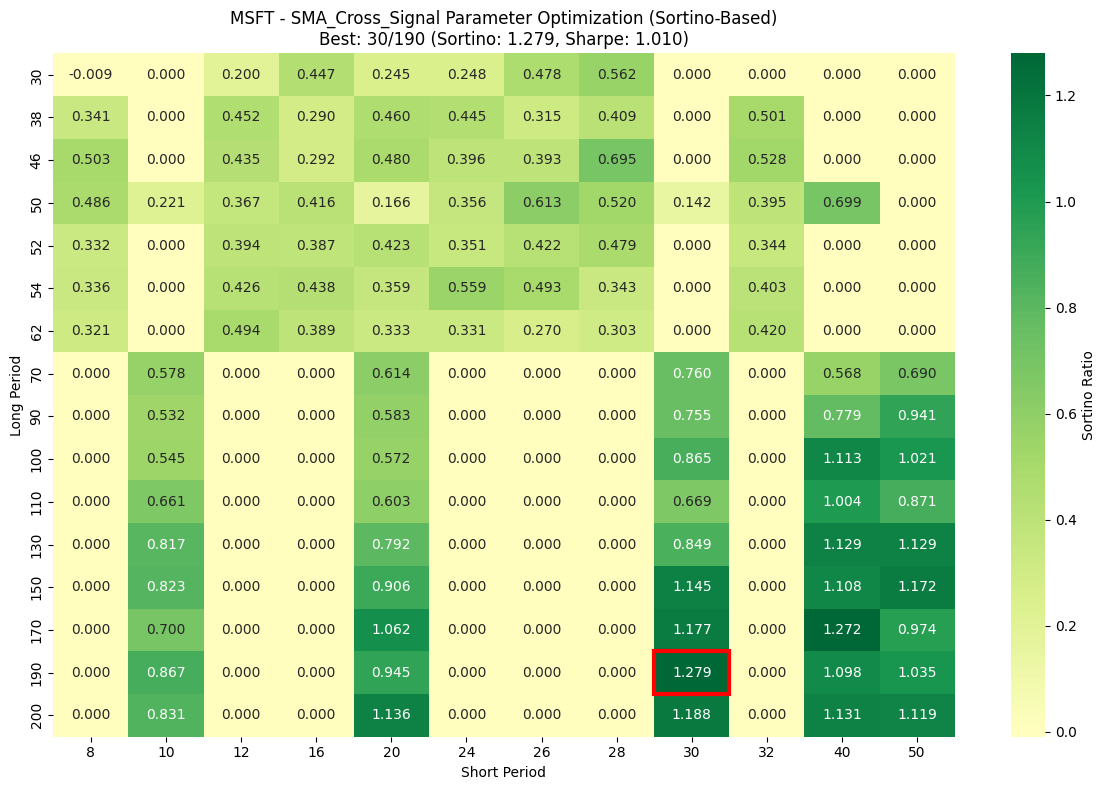

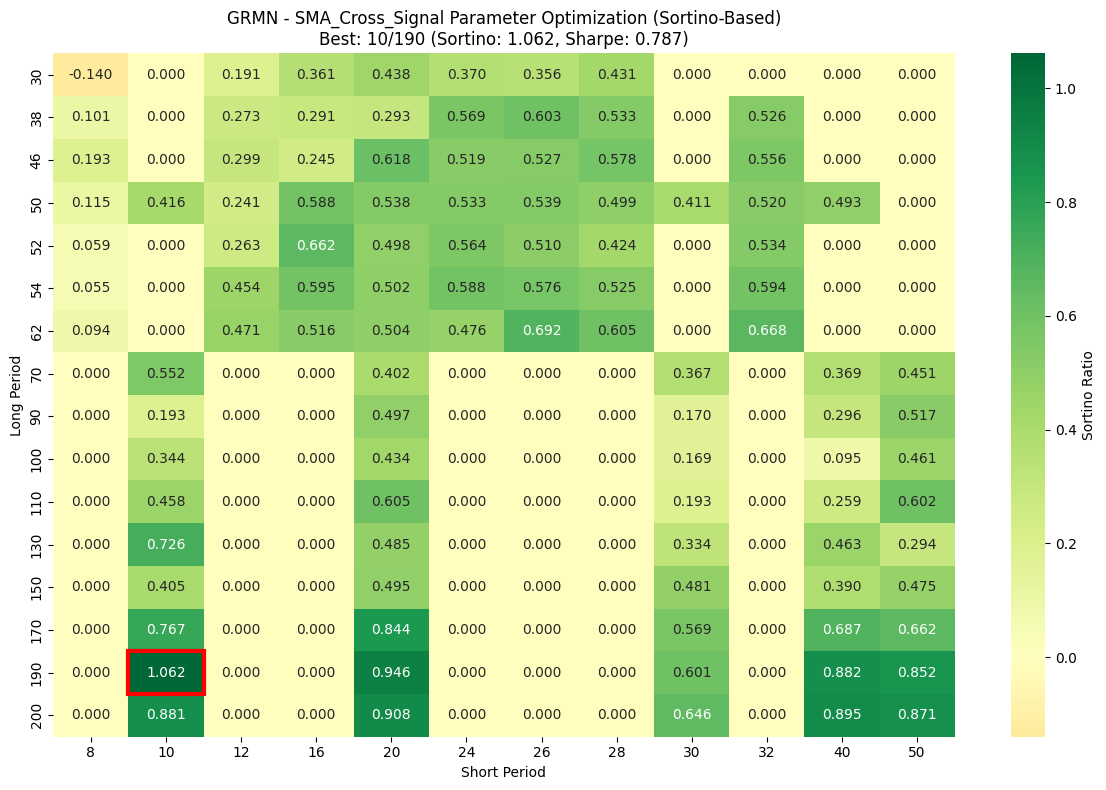

In [11]:
from py.technical_analysis import find_optimal_portfolio_with_parameter_optimization, plot_optimization_heatmaps

# Fast optimization (uses all CPU cores by default)
optimization_results = find_optimal_portfolio_with_parameter_optimization(
    quotes= training_set,
    # min_cagr= 0.1,           # Minimum 10% annual return
    max_volatility= 0.3,     # Maximum 30% volatility
    max_stocks= 2,           # Top 2 stocks by Sortino ratio
    n_jobs= 4                # Parallel processing cores
)

# Access results
optimization_summary = optimization_results['optimization_summary']
portfolio_stats = optimization_results['portfolio_stats']
selected_tickers = optimization_results['selected_tickers']

display(optimization_summary)
plot_optimization_heatmaps(optimization_results)
# plot_optimization_metrics(optimization_summary)

### Step 9: Test the Strategy -- Testing Set


🔄 Generating optimized signals for full dataset (training + test)...
Selected tickers: ['MSFT', 'GRMN']
✅ Generated optimized signals for 2 tickers

📈 Strategy Signals by Ticker:
📋 Included tickers: ['MSFT', 'GRMN']
📊 Plotting 2 tickers that passed the thresholds


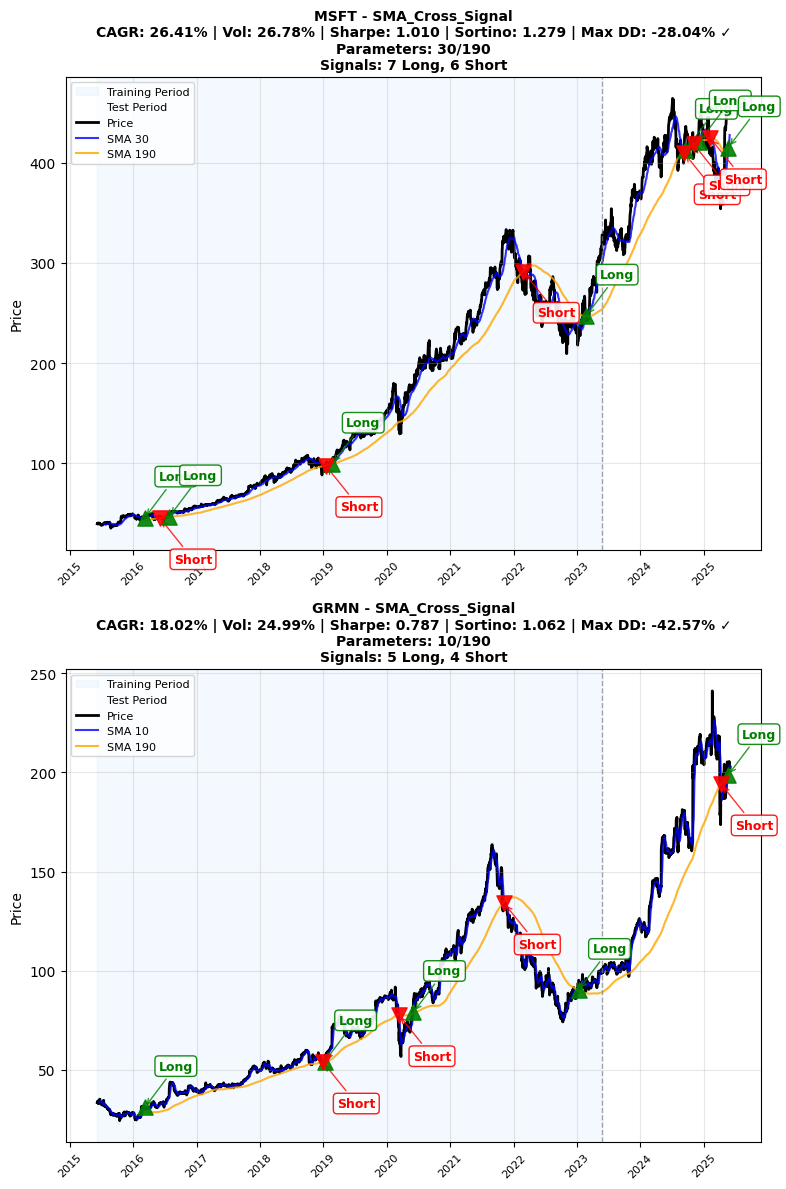


✅ Chart generation complete!


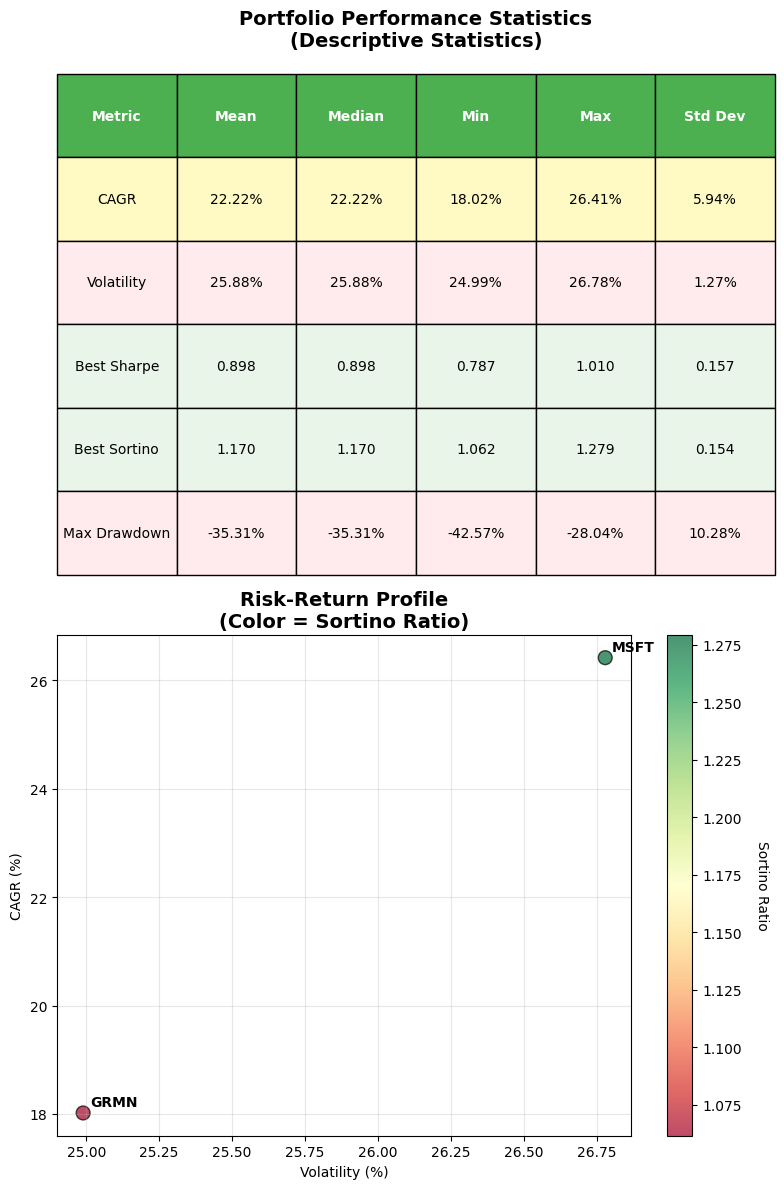


PORTFOLIO PERFORMANCE STATISTICS TABLE
Descriptive Statistics for Selected Assets (Sortino-Based Selection)
--------------------------------------------------------------------------------
      Metric    Mean  Median     Min     Max Std Dev  Count
        CAGR  22.22%  22.22%  18.02%  26.41%   5.94%      2
  Volatility  25.88%  25.88%  24.99%  26.78%   1.27%      2
 Best Sharpe   0.898   0.898   0.787   1.010   0.157      2
Best Sortino   1.170   1.170   1.062   1.279   0.154      2
Max Drawdown -35.31% -35.31% -42.57% -28.04%  10.28%      2


,Metric,Mean,Median,Min,Max,Std Dev,Count
0,CAGR,22.22%,22.22%,18.02%,26.41%,5.94%,2
1,Volatility,25.88%,25.88%,24.99%,26.78%,1.27%,2
2,Best Sharpe,0.898,0.898,0.787,1.010,0.157,2
3,Best Sortino,1.170,1.170,1.062,1.279,0.154,2
4,Max Drawdown,-35.31%,-35.31%,-42.57%,-28.04%,10.28%,2


In [16]:
from py.technical_analysis import plot_portfolio_performance, plot_complete_strategy_analysis

# Generate and plot complete strategy analysis
plot_complete_strategy_analysis(optimization_results, quotes, training_set, test_set, cols=1) # 1 column layout (vertical stack)
# plot_complete_strategy_analysis(optimization_results, quotes, training_set, test_set, cols=2, rows=2) # Fixed 2x2 grid
plot_portfolio_performance(optimization_summary, cols=1, rows=2)  # 1 column layout (vertical stack)

### Step 10: Merge Strategy with Fundamental + Sentiment Analysis Data

In [13]:
from py.utils import clean_column_names

# Use optimization_results instead of analysis_results
print("Selected tickers from optimization_results:")
print(selected_tickers)

# Create a DataFrame with tickers and merge with optimization_summary
optimization_summary_with_tickers = optimization_summary.copy()
optimization_summary_with_tickers['Ticker'] = [ticker.upper() for ticker in selected_tickers]

# Convert to Polars for merging
best_strategies_pl = pl.DataFrame(optimization_summary_with_tickers)

# Prepare comprehensive_screened for merging - select only needed columns
comprehensive_screened_for_merge = comprehensive_screened.select([
    'symbol',
    'articlesInLastWeek',
    'companyNewsScore', 
    'bearishPercent',
    'bullishPercent',
    'averageSentimentScore',
    'sectorAverageBullishPercent',
    'sectorAverageNewsScore'
]).with_columns(
    pl.col("symbol").str.to_uppercase().alias("Ticker")
).drop('symbol')

# Chain all merges together
short_term_portfolio_pl = (fundamentals_df
    .join(best_strategies_pl, on='Ticker', how='inner')
    .join(comprehensive_screened_for_merge, on='Ticker', how='inner')
)

# Convert back to pandas if needed for further processing
short_term_portfolio_df = short_term_portfolio_pl.to_pandas()
short_term_portfolio_df = short_term_portfolio_df.set_index('Ticker').sort_index()
short_term_portfolio_df = clean_column_names(short_term_portfolio_df)
display(short_term_portfolio_df)

Selected tickers from optimization_results:
['MSFT', 'GRMN']


,Date,Name,Sector,Industry,Country,Website,Market Cap,Enterprise Value,Float Shares,Shares Outstanding,...,Volatility,Short Period,Long Period,Articles In Last Week,Company News Score,Bearish Percent,Bullish Percent,Average Sentiment Score,Sector Average Bullish Percent,Sector Average News Score
Ticker,,,,,,,,,,,,,,,,,,,,,
GRMN,2025-06-02,Garmin Ltd.,Technology,Scientific & Technical Instruments,Switzerland,https://www.garmin.com,3.908005e+10,3.658406e+10,1.747949e+08,1.925410e+08,...,0.249895,10,190,5,0.6425,0.0000,0.6000,0.2850,0.5361,0.5731
MSFT,2025-06-02,Microsoft Corporation,Technology,Software - Infrastructure,United States,https://www.microsoft.com,3.421644e+12,3.447047e+12,7.422064e+09,7.432540e+09,...,0.267789,30,190,28,0.6211,0.0357,0.5714,0.2422,0.5361,0.5731


### Step 12: Export Potfolio to Excel

#### Prepare DataFrame for Export

In [14]:
# Merge Portfolio Daily Quotes with risk-free rate
daily_prices_df_merged = quotes[selected_tickers].join(daily_risk_free_df, how='inner')

# Convert all column names to uppercase
daily_prices_df_merged.columns = daily_prices_df_merged.columns.str.upper()

# Create a Monthly Price DataFrame
monthly_prices_df_merged = daily_prices_df_merged.copy()

# Make sure index is datetime (redundant if already datetime, but safe)
monthly_prices_df_merged.index = pd.to_datetime(monthly_prices_df_merged.index)

# Resample to monthly (start of month) and get the last value
monthly_prices_df_merged = (monthly_prices_df_merged
                           .resample('MS').last()
                           .reset_index()
                           .rename(columns={'index': 'Date'}))

# Set Index to Date
monthly_prices_df_merged.reset_index(drop=True, inplace=True)
monthly_prices_df_merged.set_index(['Date'], inplace=True)

# Display
display(monthly_prices_df_merged.sort_index(axis=0, ascending=False).sort_index(axis=1, ascending=True))

,GRMN,MSFT,^IRX
Date,,,
2025-05-01,202.97,460.36,4.230
2025-04-01,186.87,394.54,4.190
2025-03-01,217.13,374.70,4.190
2025-02-01,228.11,396.26,4.193
2025-01-01,215.08,413.47,4.188
...,...,...,...
2015-10-01,26.86,45.94,0.068
2015-09-01,27.17,38.63,0.005
2015-08-01,28.08,37.98,0.003


#### Export DataFrame to Excel

In [15]:
from py.utils import export_to_excel

export_to_excel(output_file, {
    'short_term': short_term_portfolio_df,
    'daily_quotes': daily_prices_df_merged,  
    'monthly_quotes': monthly_prices_df_merged   
})

Updated sheet 'short_term'
Successfully merged data into 'daily_quotes' sheet
Successfully merged data into 'monthly_quotes' sheet
Successfully exported all data to portfolios/portfolio-2025-06-02.xlsx
